In [1]:
%matplotlib inline

In [14]:
# overwrite ipython defaults
plt.rcParams["figure.facecolor"] = '17344A'
plt.rcParams["axes.facecolor"] = '17344A'
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
from IPython import display
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import warnings

In [5]:
warnings.filterwarnings("ignore")

In [7]:
import os
os.chdir("/home/ubuntu/kaggle/yelp")
os.getcwd()

'/home/ubuntu/kaggle/yelp'

In [8]:
!ls 

91627a02-ff6a-4fcb-96eb-72c6abca7515.zip
PhaseIISubmissionFormat.csv
restaurant_ids_to_yelp_ids.csv
SubmissionFormat.csv
train_labels.csv
yelp_boston_academic_dataset_updated
yelp_boston_academic_dataset_updated.tar


In [9]:
! head -n 1 yelp_boston_academic_dataset_updated/yelp_academic_dataset_review.json

{"votes": {"funny": 0, "useful": 0, "cool": 0}, "user_id": "P_Mk0ygOilLJo4_WEvabAA", "review_id": "OeT5kgUOe3vcN7H6ImVmZQ", "stars": 3, "date": "2005-08-26", "text": "This is a pretty typical cafe.  The sandwiches and wraps are good but a little overpriced and the food items are the same.  The chicken caesar salad wrap is my favorite here but everything else is pretty much par for the course.", "type": "review", "business_id": "Jp9svt7sRT4zwdbzQ8KQmw"}


In [10]:
id_map = pd.read_csv('restaurant_ids_to_yelp_ids.csv')
id_dict = {}

#each yelp ID may correspond to up to 4 Boston IDs
for i,row in id_map.iterrows():
    #get the Boston ID
    boston_id = row['restaurant_id']
    
    #get the non-null yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id]=boston_id

In [11]:
with open("yelp_boston_academic_dataset_updated/yelp_academic_dataset_review.json",'rt') as review_file:
    review_json = '[' + ','.join(review_file.readlines()) + ']'
    
#read in the json as a DataFrame
reviews = pd.read_json(review_json)

#drop columns that we won't use
reviews.drop(['review_id','type','user_id','votes'],inplace=True, axis=1)

#replace yelp business_id with boston restaurant id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
reviews.business_id = reviews.business_id.map(map_to_boston_ids)

#rename first column to restaurant_id so we can join with boston data
reviews.columns = ["restaurant_id","date","stars","text"]

#drop restaurants not found in boston data
reviews = reviews[pd.notnull(reviews.restaurant_id)]

reviews.head()

,restaurant_id,date,stars,text
0,N6Ok7qOx,2005-08-26,3,This is a pretty typical cafe. The sandwiches...
1,N6Ok7qOx,2005-11-23,3,I agree with other reviewers - this is a prett...
2,N6Ok7qOx,2005-11-23,3,"Decent enough food, but very overpriced. Just ..."
3,N6Ok7qOx,2006-02-24,5,The muffins are great...esp the blueberry! I ...
4,N6Ok7qOx,2007-09-06,3,"Well, well, well, look at me reviewing the res..."


In [12]:
train_labels = pd.read_csv('train_labels.csv', index_col=0)
submission = pd.read_csv('SubmissionFormat.csv',index_col=0)
train_labels.head()

,date,restaurant_id,*,**,***
id,,,,,
589,2010-02-02,KAoKWjog,3,0,1
28589,2009-12-10,p038M4om,2,0,0
31170,2008-07-16,B1oXymOV,4,0,0
2600,2015-01-30,m0oWJl3G,1,0,3
1016,2012-03-19,rJoQwlEV,0,0,0


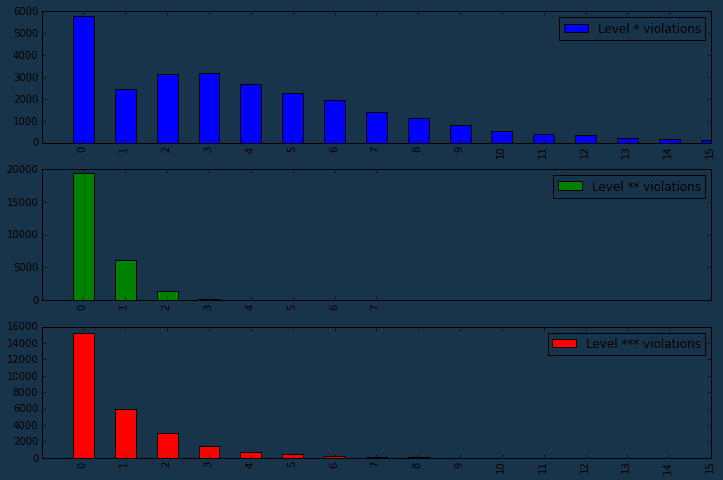

In [15]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    data = train_labels[label]
    vc = data.value_counts()
    idxs = sorted(vc.index)
    vc[idxs].plot(kind="bar",
                  ax=axs[i],
                  xlim=(-1, 15),
                  color=plt.rcParams['axes.color_cycle'][i],
                  grid=False,
                  label='Level {} violations'.format(label))
    axs[i].legend()

In [16]:
def flatten_reviews(label_df, reviews):
    """label_df:inspection dataframe with date, restaurant_id 
        reviews: dataframe of reviews
        
        Returns all of the text of reviews previous to each 
        inspection listed in label_df
    """
    
    reviews_dictionary = {}
    N = len(label_df)
    
    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that occured before the inspection
        pre_inspection_mask = (reviews.date < row.date) & (reviews.restaurant_id == row.restaurant_id)
        
        #pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]
        
        #join the text
        all_text = ' '.join(pre_inspection_reviews.text)
        
        #store in a dictionary
        reviews_dictionary[pid] = all_text
        
        if i%2500 ==0:
            print ('{} out of {}'.format(i,N))
    
    #return series in same order as the original data frame
    return pd.Series(reviews_dictionary)[label_df.index]

In [17]:
train_text = flatten_reviews(train_labels, reviews)
train_text.head()

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


id
589      i'm posting this review on behalf of my boyfri...
28589    A great addition to Peabody Square! It is an u...
31170    This is definitely the best place to eat in Bo...
2600     Well, it's nothing spectacular, but if you're ...
1016     The thinking cup has a great atmosphere, I wou...
dtype: object

In [18]:
test_text =flatten_reviews(submission,reviews)
test_text.head()

0 out of 6772
2500 out of 6772
5000 out of 6772


id
14916    I've walked by this place a lot and always won...
29767    You pick up a lunch tray when you walk in and ...
29338    Punjab Palace is the new Allston-area restaura...
7219     Every first year student at Northeastern Unive...
20979    Honestly, subpar.  Same greasy, tasty food as ...
dtype: object

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Create a TfidfVectorizer object with english stop words 
# and a maximum of 1500 features (to ensure that we can train model 
# in a reasonable amount of time).
vec = TfidfVectorizer(stop_words='english', max_features=1750, use_idf = True)

# Create the Tfidf feature matrix from the raw text
train_tfidf = vec.fit_transform(train_text)

In [23]:
pd.DataFrame(data=train_tfidf.todense(), columns=vec.get_feature_names()).iloc[:5,30:45]

,addition,admit,advice,affordable,afternoon,ago,agree,agreed,ahead,air,al,alcohol,allowed,allston,alright
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048830,0.000000,0.000000,0.000000,0,0,0.000000
1,0.040770,0.000000,0.000000,0.020733,0.000000,0.000000,0.000000,0.000000,0.010613,0.000000,0.000000,0.000000,0,0,0.000000
2,0.000000,0.000000,0.000000,0.018041,0.016143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000
3,0.005518,0.000000,0.000000,0.009354,0.001674,0.007052,0.003498,0.000000,0.001915,0.000000,0.000000,0.002047,0,0,0.003652
4,0.018684,0.007248,0.004564,0.005701,0.023804,0.002865,0.000000,0.002322,0.001946,0.014144,0.002514,0.000000,0,0,0.000000


In [24]:
train_tfidf.shape

(27088, 1750)

In [31]:
from sklearn import linear_model

#get just the targets from the training lables
train_targets = train_labels[['*','**','***']].astype(np.float64)

#create a linear regression object
ols = linear_model.LinearRegression(n_jobs=-1)

#fit that object on the training TfIdf matrix and the target variables
ols.fit(train_tfidf, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [34]:
from functools import reduce
# get the names of the features
feature_names = np.array(vec.get_feature_names())

def get_top_features(features, model, level, limit, bottom=False):
    """ Get the top (most likely to see violations) and bottom (least
        likely to see violations) features for a given model.
        
        :param features: an array of the feature names
        :param model: a fitted linear regression model
        :param level: 0, 1, 2 for *, **, *** violation levels
        :param limit: how many features to return
        :param worst: if we want the bottom features rather than the top 
    """
    # sort order for the coefficients
    sorted_coeffs = np.argsort(model.coef_[i])
    
    if bottom:
        # get the features at the end of the sorted list
        return features[sorted_coeffs[-1 * limit:]]
    else:
        # get the features at the beginning of the sorted list
        return features[sorted_coeffs[:limit]]
    
# get the features that indicate we are most and least likely to see violations
worst_feature_sets = [get_top_features(feature_names, ols, i, 100) for i in range(3)]
best_feature_sets = [get_top_features(feature_names, ols, i, 100, bottom=True) for i in range(3)]

# reduce the independent feature sets to just the ones
# that we see in common across the per-level models (*, **, ***)
worst = reduce(np.intersect1d, best_feature_sets)
best = reduce(np.intersect1d, worst_feature_sets)

# display as a pretty table
html_fmt = "<table><th>More Violations</th><th>Fewer Violations</th><tbody>{}</tbody></table>"
table_rows = ["<tr><td>{}</td><td>{}</td></tr>".format(w, b) for w, b in zip(worst, best)]
table_body = "\n".join(table_rows)
display.HTML(html_fmt.format(table_body))

absolute,appreciated
actual,basement
add,bed
advice,bigger
affordable,bone
air,checking
arrived,complain
atmosphere,concept
balance,consistency
ball,conversation
basically,cooking


In [35]:
#create the same tfidf matrix for the test set
#so we can make predictions based on the same features

test_tfidf = vec.transform(test_text)

#predict the counts for the test set
predictions = ols.predict(test_tfidf)

#clip the predictions so they are all greater than or equal to zero
# since we can't have negative counts of violations
predictions = np.clip(predictions, 0, np.inf)

In [36]:
#write the submission file
new_submission = submission.copy()
new_submission.iloc[:,-3:] = predictions.astype(int)
new_submission.to_csv("July4th_2.csv")
new_submission.head()

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,4,0,0
29767,2013-12-30,WwOaAnOB,4,0,1
29338,2011-04-08,we39kvOk,3,0,1
7219,2013-12-30,dj3d5Xo9,2,0,0
20979,2008-03-31,XJ3rBW3R,4,0,1
